# Initial (Trivial) Fitting 
- This is a very simple notebook which fits all data as a single segment, using a least squares fit.
- This is later used to inform priors on the more complex model incorporating all fragments seperatly.

In [7]:
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# Extracting the data
file_data = pd.read_csv('data/Hole_Measurements.csv')
x = file_data['Mean(X)'].values
y = file_data['Mean(Y)'].values
distances = file_data['Inter-hole Distance'].values

## Sigma
- In this we investigate the standard deviation of the interhole distance to obtain a rough estimate of their error in placements

In [30]:
# Remove nan values for edge fragments
distances = distances[~np.isnan(distances)]

# Standard deviation of the sample
std = np.std(distances, ddof=1)

print(f"Standard deviation of mean seperation: {std:.4f}")

Standard deviation of mean seperation: 0.1272


## X0, Y0 and R - Least Squares
- Simple to inform priors

In [ ]:
def fit_circle_and_angle(x, y):
    """
    Fits a circle to a set of 2D points (x, y) assuming all lie on a single arc,
    and computes the angular position (alpha) of the first point relative to the center.

    Parameters:
    ----------
    x : array-like
        x-coordinates of the points.
    y : array-like
        y-coordinates of the points.

    Returns:
    -------
    x0 : float
        Estimated x-coordinate of the circle's center.
    y0 : float
        Estimated y-coordinate of the circle's center.
    r : float
        Estimated radius of the circle.
    alpha : float
        Angular offset (in radians) of the first point relative to the fitted center.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Very simple model does not account for N
    def residuals(c):
        x0, y0, r = c
        return np.sqrt((x - x0)**2 + (y - y0)**2) - r

    # Initial guess used simply the mean of the data
    x0_init = np.mean(x)
    y0_init = np.mean(y)
    r_init = np.mean(np.sqrt((x - x0_init)**2 + (y - y0_init)**2))
    
    result = least_squares(residuals, [x0_init, y0_init, r_init])
    x0, y0, r = result.x

    # Get angular position (alpha) of the first hole
    dx = x[0] - x0
    dy = y[0] - y0
    # This returned in radians as my convention
    alpha = np.arctan2(dy, dx) 

    return x0, y0, r, alpha



In [6]:
x0, y0, r, alpha = fit_circle_and_angle(x, y)

print(f"x0 = {x0:.2f}, y0 = {y0:.2f}, r = {r:.2f}")
print(f"First hole angle (radians) = {alpha:.4f}")
print(f"First hole angle (degrees) = {np.degrees(alpha):.2f}°")

x0 = 80.47, y0 = 136.75, r = 78.43
First hole angle (radians) = -2.5440
First hole angle (degrees) = -145.76°


In [33]:
def plot_fitted_circle(x, y, x0, y0, r, alpha):
    """
    Plots a set of 2D points along with the best-fit circle and the angular offset
    of the first point relative to the circle center.

    Parameters:
    ----------
    x : array-like
        x-coordinates of the observed points.
    y : array-like
        y-coordinates of the observed points.
    x0 : float
        x-coordinate of the fitted circle's center.
    y0 : float
        y-coordinate of the fitted circle's center.
    r : float
        Radius of the fitted circle.
    alpha : float
        Angular offset (in radians) of the first point from the circle center.

    Notes:
    -----
    - Displays the fitted circle, observed points, the estimated center,
      and a line showing the angular offset from the center to the first point.
    - A text box in the upper-left corner displays the estimated parameters.
    - This function is intended for visualisation and does not return any values.
    """

    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the original hole positions
    ax.scatter(x, y, facecolors='none', edgecolors='black', s=80, label='Observed Holes', zorder=3)

    # Plot the fitted circle
    theta = np.linspace(0, 2 * np.pi, 500)
    circle_x = x0 + r * np.cos(theta)
    circle_y = y0 + r * np.sin(theta)
    ax.plot(circle_x, circle_y, linestyle='--', color='red', label='Fitted Circle')

    # Plot the center
    ax.plot(x0, y0, 'x', color='red', label='Fitted Center', markersize=8)

    # Plot line showing alpha
    ax.plot([x0, x[0]], [y0, y[0]], color='blue', linewidth=1.5, label=r'$\alpha$ (angular offset)')
    ax.text((x0 + x[0]) / 2, (y0 + y[0] + 20) / 2, r'$\alpha$', fontsize=12, color='blue')

    # Add parameter estimates box in top left corner
    alpha_deg = np.degrees(alpha)
    param_text = (
        f"$x_0$ = {x0:.2f} mm\n"
        f"$y_0$ = {y0:.2f} mm\n"
        f"$r$ = {r:.2f} mm\n"
        f"$\\alpha$ = {alpha_deg:.2f}$^\\circ$"
    )
    props = dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85)
    ax.text(0.02, 0.98, param_text, transform=ax.transAxes,
            fontsize=14, verticalalignment='top', bbox=props)

    # Styling
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('X (mm)', fontsize=16)
    ax.set_ylabel('Y (mm)', fontsize=16)
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.legend(loc='upper right', fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.show()

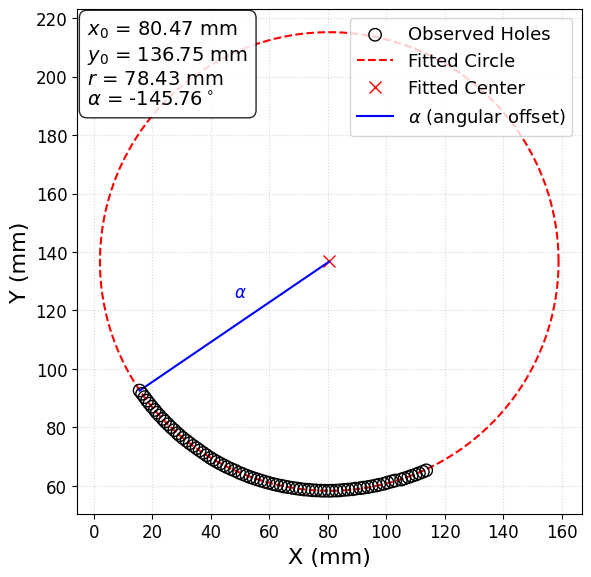

In [34]:
plot_fitted_circle(x, y, x0, y0, r, alpha)